In [1]:
from random import seed
import os, sys
os.chdir('/home/koritskiy/rqc/hamiltonian_learning')
from modules.smc import Particle, Cloud
from modules.gradient import ProbabilityDerivative, Gradient
from modules.hamiltonian import *
from modules.measurements import *
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib

name = 'ising_4'
path = 'results/' + name

In [2]:
def double_plot(Y1, Y2, Y1_name=None, Y2_name=None, fontsize=30):

    X = range(len(Y1))
    fig, ax1 = plt.subplots(figsize=(15,7))
    ax1.set_title('Кривые обучения')
    
    color = '#003f5c'
    fontsize = fontsize 
    ax1.set_xlabel('Итерации')
    if Y1_name:
        ax1.set_ylabel(Y1_name, color=color)
    else:
        ax1.set_ylabel("Y1", color=color)
    ax1.scatter(X, Y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = '#bc5090'
    if Y1_name:
        ax2.set_ylabel(Y2_name, color=color)
    else:
        ax2.set_ylabel("Y2", color=color)  # we've already handled the x-label with ax1
    ax2.scatter(X, Y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.ylim(bottom=0)
    

    matplotlib.rc('font', size=fontsize)
    plt.savefig(path + '/double_plot.png', transparent=True)
    plt.show()

In [3]:
np.random.seed(43)
seed(43)

In [170]:
n_cycles=50
n_particles=500
lr=0.5
gradient_iterations=500

# Some initial parameters
n_spins = 4
beta = 0.3

# Create initial random basis angles
theta = np.random.rand(n_spins) * np.pi
phi = np.random.rand(n_spins) * 2 * np.pi
# theta = np.array([0.])
# phi = np.array([0.])

angles = np.array([theta, phi]).T

# Create target hamiltonian
# x_t = np.random.rand(n_spins) * 2 - 1
z_t = np.random.rand(n_spins) * 2 - 1
x_t = np.random.rand(n_spins) * 2 - 1
y_t = np.random.rand(n_spins) * 2 - 1
zz_t = np.random.rand(n_spins - 1) * 2 - 1

hamiltonian_t = Hamiltonian(n_spins, beta, z=z_t, x=x_t, y=y_t, zz=zz_t)
hamiltonian_t.set_density_mat()
# print('Target density matrix')
# print(hamiltonian_t.density_mat)

# Create an initial pull of random hamiltonians
# (we call it "particle" according to Sequential Monte Carlo terminology)
g_cloud = Cloud(n_particles, n_spins, beta, coeffs_types=["z", "x", "y", 'zz'])
MSE = []
TD = []

for i in tqdm(range(n_cycles)):
    # Measure target hamiltonian
    singles_t, correlators_t = hamiltonian_t.measure(angles)

    # Update weight according to particle's distance to target hamiltonian
    g_cloud.list_weight_update(angles, singles_t, correlators_t)

    # Make a recycling wheel to get rid of far particles
    g_cloud.resampling()

    # Weighted sum of all particles -- our current best result
    # hamiltonian_g = g_cloud.weighted_sum()

    X = g_cloud.get_X()
    hamiltonian_g, _ = g_cloud.mean_vec(X)
    mse = hamiltonian_difference(hamiltonian_t, hamiltonian_g)
    MSE.append(mse)
    # print(f"iteration {i}")
#     print(f"mse {mse}")
    # # print(f"hamiltonian_g.z {hamiltonian_g.z}")
    singles_g, correlators_g = hamiltonian_g.measure(angles)
    td = distance_by_measurements(singles_g, singles_t, correlators_g, correlators_t)
    TD.append(td)
#     print(f"distance {td}")
    # print(f"theta {angles[0, 0] / np.pi}")
    # print(f"phi {angles[0, 1] / np.pi}")
    # print('')

    # Make a gradient descent to determine new angles
    grad = Gradient(hamiltonian_t, hamiltonian_g, angles)
    angles = grad.gradient_descent(lr=lr, num_iterations=gradient_iterations)
print(f"z_t = {z_t}")
print(f"z_g = {hamiltonian_g.z}")


z_t = [ 0.71956673  0.8835825  -0.77770245  0.33580404]
z_g = [ 0.56964102  0.78014113 -0.59154043  0.39250102]


In [122]:
print(f"z_t = {z_t}")
print(f"zz_t = {zz_t}")
print(f"z_g = {hamiltonian_g.z}")
print(f"zz_g = {hamiltonian_g.zz}")

z_t = [ 0.46492608  0.38182691 -0.06333159  0.80004508]
zz_t = [-0.05477358 -0.4567459  -0.08455434]
z_g = [ 0.44891321  0.3924427  -0.09834323  0.73647757]
zz_g = [-0.13340761 -0.4173771  -0.10453507]


In [128]:
def zip_cross(singles, couplings):
    n = len(singles)
    zipped = []
    for i in range(n):
        try:
            zipped.append(singles[i])
            zipped.append(couplings[i])
        except:
            pass
    return np.array(zipped)


In [175]:
def zip_cross_ext(z, x, y, zz):
    n = len(z)
    zipped = []
    for i in range(n):
        try:
            zipped.append(z[i])
            zipped.append(x[i])
            zipped.append(y[i])
            zipped.append(zz[i])
        except:
            pass
    return np.array(zipped)

In [4]:
MSE = np.genfromtxt(path + '/MSE.dat', dtype='float')
TD = np.genfromtxt(path + '/TD.dat', dtype='float')

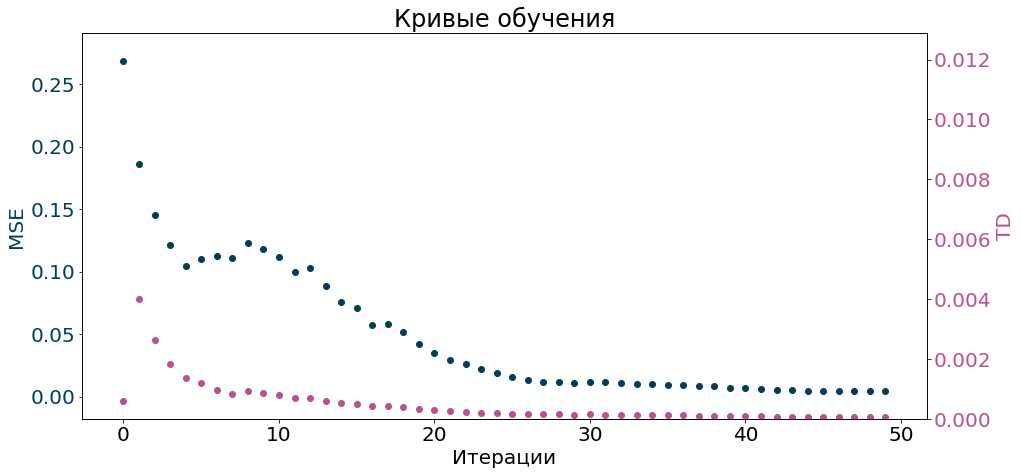

In [6]:
double_plot(MSE, TD, "MSE", "TD", fontsize=20)

In [7]:
n_spins = 4

z_t = np.random.rand(n_spins) * 2 - 1
zz_t = np.random.rand(n_spins - 1) * 2 - 1

coefs_t = np.genfromtxt(path + '/coefs_t.dat', dtype='float')
coefs_g = np.genfromtxt(path + '/coefs_g.dat', dtype='float')

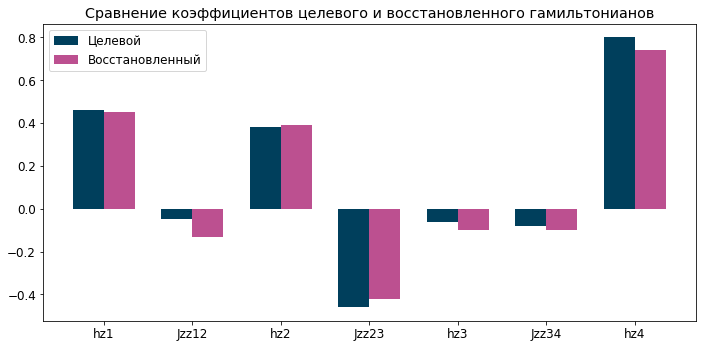

In [9]:
labels = ['hz1','Jzz12', 
          'hz2','Jzz23',
         'hz3', 'Jzz34',
         'hz4']
# coefs_t = np.round(zip_cross_ext(z_t, x_t, y_t, zz_t), decimals=2)
# coefs_g = np.round(zip_cross_ext(hamiltonian_g.z,hamiltonian_g.x,hamiltonian_g.y, hamiltonian_g.zz), decimals=2)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
color = '#003f5c'
rects1 = ax.bar(x - width/2, coefs_t, width, label='Целевой', color='#003f5c',)
# rects1.set_hatch('/')
rects2 = ax.bar(x + width/2, coefs_g, width, label='Восстановленный', color='#bc5090')

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
ax.set_title('Сравнение коэффициентов целевого и восстановленного гамильтонианов')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()

matplotlib.rc('font', size=12)
plt.savefig(path + '/bars.png', transparent=True)
plt.show()

In [185]:
np.savetxt(path + '/rho_t.dat', np.abs(hamiltonian_t.density_mat))
np.savetxt(path + '/rho_g.dat', np.abs(hamiltonian_g.density_mat))

np.savetxt(path + '/coefs_t.dat', coefs_t)
np.savetxt(path + '/coefs_g.dat', coefs_g)

np.savetxt(path + '/MSE.dat', MSE)
np.savetxt(path + '/TD.dat', TD)